In [1]:
import time
import os
import seaborn as sns
import numpy as np
import pandas as pd
import sys
%load_ext autoreload
%autoreload 2
from mimas.tools.spectral_file.extract_ms1_feature import process_mzml_file, extract_ms2_spectra, find_features
import logging
from toolsets.std_list_prep import complete_adducts, complete_formula
# from toolsets.API_gets import complete_smiles
from toolsets.search import string_search, num_search
import toolsets.spectra_operations as so
from tqdm import tqdm
from toolsets.features_by_alphapept import find_features_alphapept
import matplotlib.pyplot as plt
import seaborn as sns
source_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/EAD'
feature_folder = ('/Users/fanzhoukong/Documents/GitHub/Libgen_data/EAD/features')
source_dir = ('/Users/fanzhoukong/Documents/GitHub/Libgen_data/EAD/')

# prep std lists

In [7]:
# from toolsets.std_list_prep import crude_list_cleanup
# std_list_crude_pfp = pd.read_csv('/Users/fanzhoukong/Documents/GitHub/Libgen_data/EAD/PFP_std_list_crude.csv')
# std_list_crude_hilic = pd.read_csv('/Users/fanzhoukong/Documents/GitHub/Libgen_data/EAD/HILIC_std_list_crude.csv')
# std_list_pfp =crude_list_cleanup(std_list_crude_pfp)
# std_list_hilic =crude_list_cleanup(std_list_crude_hilic)
#
# std_list_hilic.to_csv(os.path.join(source_dir, 'std_list_hilic_cleaned.csv'), index = False)
# std_list_pfp.to_csv(os.path.join(source_dir, 'std_list_pfp_cleaned.csv'), index = False)

In [8]:
old_lib = pd.read_csv('/Users/fanzhoukong/Documents/GitHub/Libgen_data/EAD/legacy/data_r_u.csv')

# creating library for pfp

In [2]:
std_list_pfp = pd.read_csv(os.path.join(source_dir, 'std_list_pfp_cleaned.csv'))
std_list_hilic = pd.read_csv(os.path.join(source_dir, 'std_list_hilic_cleaned.csv'))

In [154]:
from toolsets.precursor_matching import precursor_matching_global

In [3]:
from toolsets.precursor_matching import precursor_matching_global
matched_pfp = precursor_matching_global(std_list_pfp, feature_folder, adducts = ['[M]+','[M+H]+', '[M+Na]+', '[M+NH4]+', '[M-H2O+H]+'],step=10, ppm = True, comment='PFP')
matched_hilic = precursor_matching_global(std_list_hilic, feature_folder, adducts = ['[M]+','[M+H]+', '[M+Na]+', '[M+NH4]+', '[M-H2O+H]+'],step=10, ppm = True, comment='HILIC')

cleaning spectrum...


100%|██████████| 5102/5102 [02:42<00:00, 31.39it/s]


there is either multiple or none feature file for this Bile acids 2
there is either multiple or none feature file for this GC LIB 3
cleaning spectrum...


100%|██████████| 1115/1115 [00:28<00:00, 38.57it/s]


In [4]:
from toolsets.deduplication import match_by_rt
matched_mapped_pfp, matched_unmapped_pfp , matched_not_found_pfp= match_by_rt([matched_pfp])
matched_mapped_hilic, matched_unmapped_hilic , matched_not_found_hilic= match_by_rt([matched_hilic])

finding seed...


100%|██████████| 1377/1377 [00:02<00:00, 473.55it/s]


making matches


100%|██████████| 1311/1311 [00:02<00:00, 599.54it/s]


finding seed...


100%|██████████| 627/627 [00:00<00:00, 638.44it/s]


making matches


100%|██████████| 601/601 [00:00<00:00, 649.62it/s]


In [61]:
from toolsets.spectra_plotter import ms2_plot

In [11]:
from toolsets.mass_recalibration import data_recalibrate
matched_mapped_pfp = data_recalibrate(matched_mapped_pfp)
matched_mapped_hilic = data_recalibrate(matched_mapped_hilic)

100%|██████████| 73/73 [00:00<00:00, 210.80it/s]


In [14]:
matched_mapped_all = pd.concat([matched_mapped_hilic, matched_mapped_pfp], axis=0, ignore_index=True)

In [17]:
matched_mapped_all.to_csv(os.path.join(source_dir, 'matched_mapped_with_duplicates_all.csv'), index=False)

In [7]:
from toolsets.spectra_operations import weighted_average_spectra
for dataset in [matched_mapped_pfp,matched_mapped_hilic]:
    wa_spctra = []
    wa_rts = []
    for key in tqdm(dataset['key'].unique()):
        adduct_temp = string_search(dataset,'key',key)
        wa_spctrum = weighted_average_spectra(adduct_temp,typeofmsms = 'peaks_recalibrated')
        wa_rt =(adduct_temp['retention_time']*adduct_temp['ms1_precursor_intensity']/adduct_temp['ms1_precursor_intensity'].sum()).sum()
        wa_spctra.extend([wa_spctrum]*len(adduct_temp))
        wa_rts.extend([wa_rt]*len(adduct_temp))
    dataset['peaks_recalibrated_wa']=wa_spctra
    dataset['retention_time_wa']=wa_rts
    dataset.sort_values(by = ['key','ms1_precursor_intensity'], ascending=False, inplace=True)
    dataset.drop_duplicates('key', keep='first', inplace=True)

100%|██████████| 783/783 [00:25<00:00, 30.47it/s]


In [14]:
for dataset in [matched_mapped_pfp,matched_mapped_hilic]:
    dataset.to_csv(os.path.join(source_dir, get_df_name(dataset)+"_for_denoise_new.csv"), index = False)

In [120]:
matched_mapped_pfp= pd.read_csv(os.path.join(source_dir, 'matched_mapped_pfp_for_denoise_new.csv'))
matched_mapped_hilic= pd.read_csv(os.path.join(source_dir, 'matched_mapped_hilic_for_denoise_new.csv'))

In [143]:
matched_mapped_denoise = pd.concat([matched_mapped_pfp, matched_mapped_hilic], axis=0, ignore_index=True)

In [145]:
matched_mapped_denoise.to_csv(os.path.join(source_dir, 'matched_mapped_denoise.csv'), index = False)

# start here is after denoising

In [8]:
data_ead = pd.read_csv(os.path.join(source_dir, 'matched_mapped_denoise_denoised.csv'))
data_ead['c_id']=np.arange(len(data_ead))

In [9]:
len(data_ead['reference_inchikey'].unique())

1924

In [151]:
from toolsets.denoising_related_functions import post_processing
data_ead_good = post_processing(data_ead, high_quality=True)
data_ead_bad = post_processing(data_ead, high_quality=False)

In [161]:
data_ead_good.columns

Index(['scan_number', 'precursor_mz', 'charge', 'ms1_intensity_ratio',
       'ms1_precursor_intensity', 'retention_time', 'peaks', 'ms1_index',
       'query_idx', 'reference_name', 'reference_inchikey', 'reference_mix',
       'reference_smiles', 'reference_formula', 'reference_mono_mass',
       'reference_formal_charges', 'reference_adduct',
       'reference_precursor_mz', 'key', 'spectrum_entropy', 'comment',
       'rt_match_id', 'reference_inchikey_14', 'hits_rt', 'seed_found',
       'matched_rt', 'calibration', 'peaks_recalibrated',
       'peaks_recalibrated_wa', 'retention_time_wa', 'peaks_denoised', 'ei',
       'c_id', 'peaks_denoised_normalized', 'normalized_entropy',
       'normalized_entropy_raw'],
      dtype='object')

In [163]:

wa_spectrum = []
for key in data_ead_good['key'].unique():
    data_temp = string_search(data_ead_good,'key',key)
    if len(data_temp)>1:
        wa_spectrum.append(so.weighted_average_spectra(data_temp,typeofmsms='peaks_denoised_normalized'))
    else:
        wa_spectrum.append(data_temp.iloc[0]['peaks_denoised_normalized'])
data_ead_good.drop_duplicates('key', keep='first', inplace=True)
data_ead_good['peaks_denoised_normalized']=wa_spectrum

In [164]:
data_ead_good

,scan_number,precursor_mz,charge,ms1_intensity_ratio,ms1_precursor_intensity,retention_time,peaks,ms1_index,query_idx,reference_name,...,calibration,peaks_recalibrated,peaks_recalibrated_wa,retention_time_wa,peaks_denoised,ei,c_id,peaks_denoised_normalized,normalized_entropy,normalized_entropy_raw
0,523,749.299550,1,0.968634,42586.0,1.578950,127.055244\t0.00451007\n128.060577\t0.01033574...,329,193,"(2R,3S,4S,5R,6R)-6-[1,7-bis(4-hydroxyphenyl)he...",...,recalibrated_,127.055455\t0.00451007\n128.060788\t0.01033574...,50.015493\t0.002077\n51.023041\t0.00914998\n52...,1.566822,50.015493\t0.002077\n51.023041\t0.00914998\n52...,100.00000,0,50.015493\t0.002077\n51.023041\t0.00914998\n52...,0.474286,0.474286
1,518,744.344402,1,0.999243,295804.0,1.568617,50.014946\t0.003061\n51.023922\t0.01373499\n53...,328,189,"(2R,3S,4S,5R,6R)-6-[1,7-bis(4-hydroxyphenyl)he...",...,recalibrated_,50.015203\t0.003061\n51.024178\t0.01373499\n53...,50.015203\t0.003061\n51.024178\t0.01373499\n53...,1.568617,50.015203\t0.003061\n51.024178\t0.01373499\n53...,100.00000,1,50.015203\t0.003061\n51.024178\t0.01373499\n53...,0.563655,0.563655
2,521,727.317616,1,0.712541,5892.0,1.575500,127.054512\t0.00603489\n128.061432\t0.01494435...,328,191,"(2R,3S,4S,5R,6R)-6-[1,7-bis(4-hydroxyphenyl)he...",...,recalibrated_,127.054723\t0.00603489\n128.061643\t0.01494435...,127.054973\t0.00664201\n128.061881\t0.01696303...,1.568086,127.054973\t0.00664201\n128.061881\t0.01696303...,100.00000,2,127.054973\t0.00664201\n128.061881\t0.01696303...,0.449299,0.449299
3,734,1205.496037,1,0.907086,7732.0,2.293450,127.054962\t0.01068208\n128.060287\t0.04754418...,453,280,"[(2R,3R,4R,6S)-6-[[(6S,7S)-6-[(2S,4R,5R,6R)-4-...",...,recalibrated_,127.055025\t0.01068208\n128.06035\t0.04754418\...,127.055025\t0.01068204\n128.06035\t0.04754419\...,2.293450,127.055025\t0.01068204\n128.06035\t0.04754419\...,99.48690,3,127.055025\t0.01073713\n128.06035\t0.0477894\n...,0.727409,0.726956
4,500,147.043749,1,0.932898,12429.0,1.552283,50.015636\t0.00856899\n51.022392\t0.02365398\n...,274,219,COUMARIN,...,recalibrated_,50.015401\t0.00856899\n51.022159\t0.02365398\n...,50.015401\t0.00856899\n51.022159\t0.02365398\n...,1.552283,50.015401\t0.00856899\n51.022159\t0.02365398\n...,90.13491,4,50.015401\t0.00950685\n51.022159\t0.02624286\n...,0.333110,0.339807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3266,602,216.041965,1,0.910186,4307.0,1.844333,50.015682\t0.004411\n51.023666\t0.01375799\n52...,574,26,3-Chloro-L-Tyrosine,...,recalibrated_,50.016057\t0.004411\n51.02404\t0.01375799\n52....,50.016057\t0.004411\n51.02404\t0.01375799\n52....,1.844333,50.016057\t0.004411\n51.02404\t0.01375799\n52....,100.00000,3503,50.016057\t0.004411\n51.02404\t0.01375799\n52....,0.426684,0.426684
3267,62,880.717334,1,0.912145,1765.0,0.176200,50.01495\t0.00908773\n51.02256\t0.02692029\n52...,59,1,Coenzyme Q10,...,recalibrated_,50.014976\t0.00908773\n51.022587\t0.02692029\n...,50.014976\t0.009088\n51.022587\t0.02692\n52.02...,0.176200,50.014976\t0.009088\n51.022587\t0.02692\n52.02...,98.07570,3504,50.014976\t0.00926631\n51.022587\t0.02744819\n...,0.556103,0.557658
3269,72,448.199329,1,0.964788,29180.0,0.188150,140.052399\t0.00555222\n141.06131\t0.01504695\...,63,8,(2S)-N-methyl-2-[[2-(2-methyl-1H-indol-3-yl)ac...,...,recalibrated_,140.052206\t0.00555222\n141.061119\t0.01504695...,140.052206\t0.00555199\n141.061119\t0.01504698...,0.188150,140.052206\t0.00555199\n141.061119\t0.01504698...,98.16850,3506,140.052206\t0.00565557\n141.061119\t0.01532771...,0.350960,0.358289
3270,71,426.217639,1,0.997481,373440.0,0.187283,127.054665\t0.010525\n128.050476\t0.008717\n14...,63,7,(2S)-N-methyl-2-[[2-(2-methyl-1H-indol-3-yl)ac...,...,recalibrated_,127.054449\t0.010525\n128.050261\t0.008717\n14...,127.054449\t0.010525\n128.050261\t0.008717\n14...,0.187283,127.054449\t0.010525\n128.050261\t0.008717\n14...,99.01960,3507,127.054449\t0.01062921\n128.050261\t0.00880331...,0.170014,0.166575


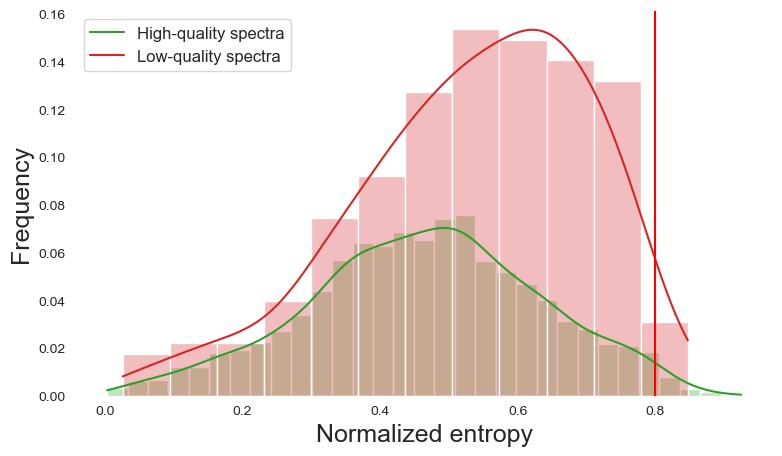

In [167]:
normalized_raw = []
for index, row in data_ead_bad.iterrows():
    normalized_raw.append(so.normalized_entropy(row['peaks_recalibrated_wa']))
data_ead_bad['normalized_entropy_raw']=normalized_raw
normalized_raw = []
for index, row in data_ead_good.iterrows():
    normalized_raw.append(so.normalized_entropy(row['peaks_recalibrated_wa']))
data_ead_good['normalized_entropy_raw']=normalized_raw
fig, ax = plt.subplots(
    figsize = (9, 5)
                      )
# ax= sns.histplot(data=data_UVPD, x="normalized_entropy", multiple="stack", kde = True, palette="red")
# ax = sns.histplot(data=data_HCD, x="normalized_entropy", multiple="stack", kde = True,color="green")
ax=sns.histplot(data=data_ead_good, x='normalized_entropy_raw', multiple="stack",color = sns.color_palette()[2], alpha = 0.3,stat='probability',kde=True)
ax=sns.histplot(data=data_ead_bad, x='normalized_entropy_raw', multiple="stack",color = sns.color_palette()[3], alpha = 0.3,stat='probability',kde=True)
plt.axvline(0.8, 0, color = 'red' )
# ax=sns.histplot(data=data_uvpd_good, x='normalized_entropy_raw', multiple="stack",color = sns.color_palette("Set2")[0], stat='probability')
# ax=sns.histplot(data=data_uvpd_bad, x='normalized_entropy_raw', multiple="stack",color = sns.color_palette("Set2")[1],stat='probability')
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Normalized entropy", fontsize = 18)
ax.set_ylabel("Frequency", fontsize = 18)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend(labels=["High-quality spectra","Low-quality spectra"], loc = 'upper left',fontsize=12)
# plt.savefig(os.path.join(source_dir,'normalized_entropy_UVPD_high_low_quality.tiff'), dpi = 300,transparency = True,facecolor = 'white', edgecolor = 'white')

In [169]:
from toolsets.file_io import export_library_msp

In [170]:
data_ead_good.to_csv(os.path.join(source_dir, 'EAD_library'), index= False)
export_library_msp(data_ead_good,os.path.join(source_dir, 'EAD_library_final.txt'), typeofmsms='peaks_denoised_normalized')
# export_library_msp(data_hilic,os.path.join(source_dir, 'EAD_hilic_final.txt'), typeofmsms='peaks_denoised_normalized')

100%|██████████| 3260/3260 [00:22<00:00, 147.68it/s]


In [171]:
from toolsets.API_gets import GNPS_classyfire, get_classyfire_data
data_EAD=pd.read_csv(os.path.join(source_dir, 'EAD_library.csv'))
data_EAD_classyfire= get_classyfire_data(data_EAD)

100%|██████████| 3244/3244 [16:27<00:00,  3.29it/s]


In [173]:
data_EAD_classyfire.to_csv(os.path.join(source_dir, 'EAD_library_cla.csv'), index = False)

# test some denoising

In [1]:
from toolsets.denoising_related_functions import denoise_single

In [15]:
from rdkit import Chem

In [9]:
denoise_single(105.0447, 212.0837, adduct='[M+H]+', formula = 'C11H14ClN3O', mass_error= 20, ifppm=True)

['H5C6NO', 'H8C3N2Cl']

In [10]:
test_smiles= 'CC(C)N(C1=CC=CC=C1)C(=O)CCl'

In [16]:
mol = Chem.MolFromSmiles(test_smiles)

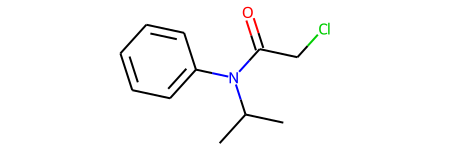

In [35]:
mol

In [96]:
benzene_pattern = Chem.MolFromSmiles('C1=CC=CC=C1')

In [113]:
mol2 = Chem.MolFromSmiles(matched_mapped_pfp.iloc[30]['reference_smiles'])

In [117]:
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
formula = CalcMolFormula(mol2)

In [119]:
matched_mapped_pfp['reference_adduct'].value_counts()

[M+H]+        1006
[M+Na]+        979
[M+NH4]+       699
[M-H2O+H]+      41
[M]+             1
Name: reference_adduct, dtype: int64

In [115]:
mol2.HasSubstructMatch(benzene_pattern)

False

In [95]:
mol.HasSubstructMatch(benzene_pattern)

True

# search biological samples

In [3]:
data_pfp = pd.read_csv(os.path.join(source_dir, 'data_pfp_lib_final.csv'))
data_hilic = pd.read_csv(os.path.join(source_dir, 'data_hilic_lib_final.csv'))

In [5]:
from toolsets.API_gets import get_classyfire_data

In [6]:
data_pfp_classyfire = get_classyfire_data(data_pfp)
data_hilic_classyfire = get_classyfire_data(data_hilic)

100%|██████████| 706/706 [03:15<00:00,  3.62it/s]


In [8]:
data_pfp_classyfire.to_csv(os.path.join(source_dir, 'data_pfp_lib_final.csv_cla'), index= False)
data_hilic_classyfire.to_csv(os.path.join(source_dir, 'data_hilic_lib_final_cla.csv'), index= False)

In [21]:
data_ead = pd.concat([data_pfp, data_hilic], axis= 0, ignore_index=True)

In [48]:
from toolsets.file_io import read_msp_files
pfp_bio =read_msp_files('/Users/fanzhoukong/Documents/GitHub/Libgen_data/EAD/biological_samples/PFP_pos.msp')
hilic_bio = read_msp_files('/Users/fanzhoukong/Documents/GitHub/Libgen_data/EAD/biological_samples/HILIC_pos.msp')

cleaning incoming spectrum


100%|██████████| 2431/2431 [02:28<00:00, 16.36it/s]


cleaning incoming spectrum


100%|██████████| 3333/3333 [04:27<00:00, 12.47it/s]


In [49]:
pfp_bio.to_csv(os.path.join(source_dir, 'pfp_bio_cleaned.csv'), index = False)
hilic_bio.to_csv(os.path.join(source_dir, 'hilic_bio_cleaned.csv'), index = False)

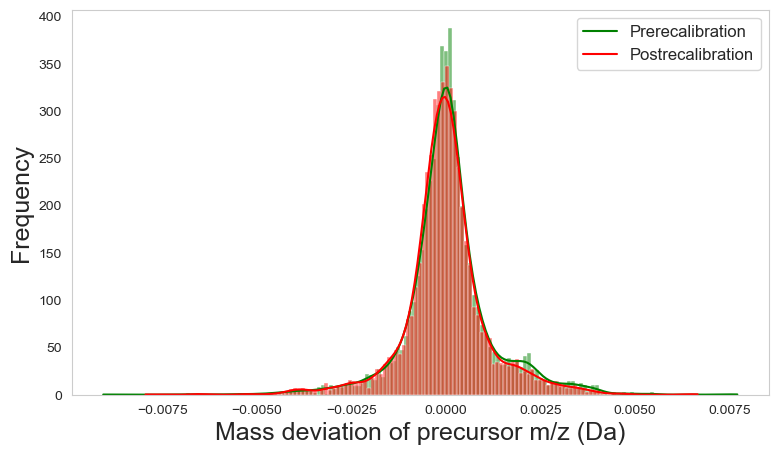

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(
    figsize = (9, 5)
                      )
ax= sns.histplot(data=data_r, x="diff_raw", multiple="stack", kde = True, color = 'green')
ax = sns.histplot(data=data_r, x="diff_recalibrated", multiple="stack", kde = True,color = 'red')
# ax.set_title("", fontsize = 16)
ax.set_xlabel("Mass deviation of precursor m/z (Da)", fontsize = 18)
ax.set_ylabel("Frequency", fontsize = 18)
ax.grid(False)
plt.legend(labels=["Prerecalibration","Postrecalibration"], loc = 'upper right',fontsize=12)
plt.savefig(os.path.join('/Users/fanzhoukong/Documents/GitHub/Libgen_data/EAD', 'recalibration.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

In [1]:
from toolsets.spectra_plotter import fast_EIC

i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot


In [ ]:
fast_EIC()

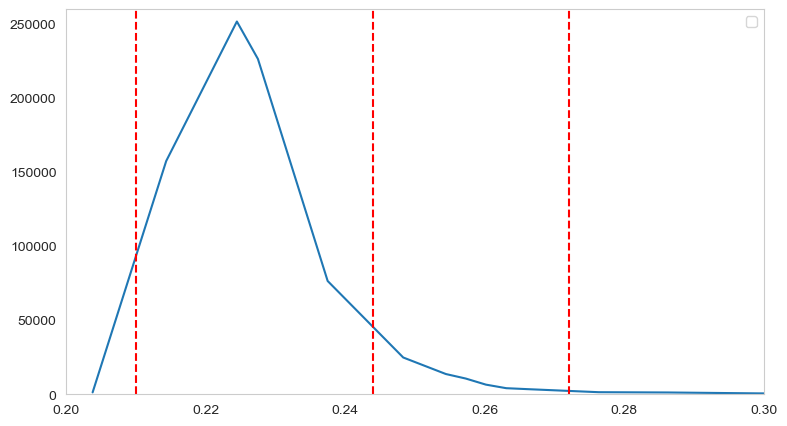

In [172]:
fig, ax = plt.subplots(
    figsize = (9, 5)
                      )
ax= sns.lineplot(rt, intensity)

# ax.set_title("Peak number difference after denoising", fontsize = 16)
# ax.set_xlabel("Precursor m/z (Da)", fontsize = 18)
# ax.set_ylabel("Mass deviation (Da)", fontsize = 18)
ax.set_xlim(0.2, 0.3)
ax.set_ylim(0, 260000)
for index, row in data_temp.iterrows():
    plt.axvline(x = row['retention_time'], color = 'red',  linestyle ="--")
    # plt.text(row['retention_time'],row['ms1_precursor_intensity'],'RT: '+str(row['retention_time'])+" MS1 intensity: "+str(row['ms1_precursor_intensity']),rotation=0)
plt.legend()

ax.grid(False)
# plt.legend(labels=["Precalibration",'Postcalibration'], loc = 'upper right',fontsize=16)
plt.savefig(os.path.join(source_dir,'demo_duplicate_xic.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

In [173]:
from toolsets.ms2_spectra_plotter import ms2_plot

In [116]:
for key in data_r['key'].unique():
    data_temp = string_search(data_r,'key',key)
    if len(data_temp)>4:
        break

In [117]:
data_temp

,scan_number,precursor_mz,charge,ms1_intensity_ratio,ms1_precursor_intensity,retention_time,peaks,ms1_index,query_idx,reference_Name,...,reference_Formula,reference_Monoisotopic mass,reference_column,reference_adduct,reference_precursor_mz,key,comments,peaks_recalibrated,diff_raw,diff_recalibrated
459,167,355.176743,1,0.992603,461889.0,0.299050,141.072433\t26.553855\n142.078049\t5.173703\n1...,69,96,Iclaprim,...,C19H22N4O3,354.169191,HILIC,[M+H]+,355.1765,HWJPWWYTGBZDEG-UHFFFAOYSA-N[M+H]+,recalibrated_,141.072449\t26.553855\n142.078065\t5.173703\n1...,0.000243,0.000174
460,194,355.176357,1,0.992090,51295.0,0.329883,139.05275\t4.70916\n141.06987\t10.28056\n148.0...,72,120,Iclaprim,...,C19H22N4O3,354.169191,HILIC,[M+H]+,355.1765,HWJPWWYTGBZDEG-UHFFFAOYSA-N[M+H]+,recalibrated_,139.052767\t4.70916\n141.069886\t10.28056\n148...,-0.000143,-0.000211
461,222,355.176576,1,0.976580,23101.0,0.381650,139.053894\t4.19372\n141.066879\t11.857371\n14...,77,143,Iclaprim,...,C19H22N4O3,354.169191,HILIC,[M+H]+,355.1765,HWJPWWYTGBZDEG-UHFFFAOYSA-N[M+H]+,recalibrated_,139.053911\t4.19372\n141.066895\t11.857371\n14...,0.000076,0.000008
462,261,355.176525,1,0.996105,65474.0,0.481267,51.0223618\t7.804189\n54.0340004\t7.862366\n60...,87,173,Iclaprim,...,C19H22N4O3,354.169191,HILIC,[M+H]+,355.1765,HWJPWWYTGBZDEG-UHFFFAOYSA-N[M+H]+,recalibrated_,51.022413\t7.804189\n54.034051\t7.862366\n60.0...,0.000025,-0.000043
463,158,355.176682,1,0.993988,492034.0,0.288950,141.06995\t12.122736\n152.0643\t5.308776\n153....,68,88,Iclaprim,...,C19H22N4O3,354.169191,HILIC,[M+H]+,355.1765,HWJPWWYTGBZDEG-UHFFFAOYSA-N[M+H]+,recalibrated_,141.069966\t12.122736\n152.064312\t5.308776\n1...,0.000182,0.000114


In [123]:
from toolsets.spectra_operations import weighted_average_spectra
spike_cols = [col for col in data_r.columns if 'reference' in col]
spike_cols.extend(['retention_time', 'peaks_recalibrated'])
data_r_u = {}
for item in spike_cols:
    data_r_u[str(item)]= []
for key in tqdm(data_r['key'].unique()):
    data_temp = string_search(data_r, 'key', key)
    instance_max = data_temp.loc[data_temp['ms1_precursor_intensity'].idxmax()]
    # if(len(data_temp)>3):
    #     break
    # concensus_spectra_temp = (weighted_average_spectra(data_temp, typeofmsms = 'peaks_recalibrated'))

    for item in spike_cols:
        if item != 'peaks_recalibrated':
            data_r_u[str(item)].append(instance_max[str(item)])
        else:
            data_r_u[str(item)].append((weighted_average_spectra(data_temp, typeofmsms = 'peaks_recalibrated')))

100%|██████████| 3529/3529 [04:55<00:00, 11.94it/s]


In [98]:
data_d.to_csv(os.path.join(source_dir, 'data_d.csv'), index = False)

# Generating figures

In [ ]:
pfp_bio

In [8]:
from toolsets.msms_search import entropy_search_fast

i am msms_search!!!!!


In [12]:
search_result = pd.DataFrame()
entropy_similarity_searched = []
unknown_precursormz = []
unknown_adduct = []
unknown_rt = []
unknown_peaks = []
for index, row in tqdm(hilic_bio.iterrows(),total=len(hilic_bio)):
    result_temp = entropy_search_fast(row['peaks'], row['PRECURSORMZ'], library = library)
    if pd.isnull(result_temp)==False:
        unknown_precursormz.append(row['PRECURSORMZ'])
        unknown_adduct.append(row['PRECURSORTYPE'])
        unknown_rt.append(row['RETENTIONTIME'])
        unknown_peaks.append(row['peaks'])
        entropy_similarity_searched.append(result_temp[0])
        search_result=search_result.append(result_temp[1])
search_result['entropy_similarity']=entropy_similarity_searched
search_result.insert(0, 'unknown_precursormz',unknown_precursormz)
search_result.insert(1, 'unknown_adduct',unknown_adduct)
search_result.insert(2, 'unknown_rt',unknown_rt)
search_result.insert(3, 'unknown_peaks',unknown_peaks)

100%|██████████| 3333/3333 [00:05<00:00, 617.20it/s] 


In [11]:
search_result.to_csv(os.path.join(source_dir, "pfp_searched_result.csv"))


In [13]:
search_result.to_csv(os.path.join(source_dir, "hilic_searched_result.csv"))

In [43]:
search_result = pd.DataFrame()

In [49]:
search_result

,reference_Name,reference_InChIKey,reference_Mix,reference_Formula,reference_Monoisotopic mass,reference_adduct,reference_precursor_mz,retention_time,peaks_recalibrated,peaks_recalibrated_denoised,comments
654,"N,N-Dimethylarginine",YDGMGEXADBMOMJ-LURJTMIESA-N,MSMLS 13,C8H18N4O2,202.142976,[M+H]+,203.1503,2.273317,55.040665\t1.363483\n56.042935\t2.780965\n57.0...,55.040665\t1.363483\n56.042935\t2.780965\n57.0...,denoised
654,"N,N-Dimethylarginine",YDGMGEXADBMOMJ-LURJTMIESA-N,MSMLS 13,C8H18N4O2,202.142976,[M+H]+,203.1503,2.273317,55.040665\t1.363483\n56.042935\t2.780965\n57.0...,55.040665\t1.363483\n56.042935\t2.780965\n57.0...,denoised


In [42]:
result[1]

reference_Name                                              N,N-Dimethylarginine
reference_InChIKey                                   YDGMGEXADBMOMJ-LURJTMIESA-N
reference_Mix                                                           MSMLS 13
reference_Formula                                                      C8H18N4O2
reference_Monoisotopic mass                                           202.142976
reference_adduct                                                          [M+H]+
reference_precursor_mz                                                  203.1503
retention_time                                                          2.273317
peaks_recalibrated             55.040665\t1.363483\n56.042935\t2.780965\n57.0...
peaks_recalibrated_denoised    55.040665\t1.363483\n56.042935\t2.780965\n57.0...
comments                                                                denoised
Name: 654, dtype: object

In [28]:
result = entropy_search_fast(row['peaks'], row['PRECURSORMZ'], library = library)

In [30]:
pd.isnull(entropy_search_fast(row['peaks'], row['PRECURSORMZ'], library = library))

True

In [1]:
hilic_bio

NameError: name 'hilic_bio' is not defined

In [3]:
data

,reference_Name,reference_InChIKey,reference_Mix,reference_Formula,reference_Monoisotopic mass,reference_adduct,reference_precursor_mz,retention_time,peaks_recalibrated,peaks_recalibrated_denoised,comments
0,Tauroursodeoxycholic acid,BHTRKEVKTKCXOH-LBSADWJPSA-N,Bile acids 1,C26H45NO6S,499.296759,[M+H]+,500.3040,5.751050,51.024371\t3.514247\n55.057286\t1.316147\n63.0...,51.024371\t3.514247\n55.057286\t1.316147\n63.0...,denoised
1,Taurodehydrocholate,UBDJSBRKNHQFPD-PYGYYAGESA-N,Bile acids 1,C26H39NO7S,509.244724,[M+H]+,510.2520,2.198233,50.017549\t3.52349\n51.025134\t11.744967\n53.0...,50.017549\t3.52349\n51.025134\t11.744967\n53.0...,denoised
2,Glycochenodeoxycholic acid,GHCZAUBVMUEKKP-GYPHWSFCSA-N,Bile acids 1,C26H43NO5,449.314123,[M+H]+,450.3214,2.304017,50.016725\t1.639344\n51.025122\t5.071469\n53.0...,50.016725\t1.639344\n51.025122\t5.071469\n53.0...,denoised
3,Deoxycholic Acid,KXGVEGMKQFWNSR-LLQZFEROSA-N,PFPpos_POS 2_EAD,C24H40O4,392.292660,[M+H]+,393.2999,2.302233,50.015884\t7.533414\n51.023678\t20.291616\n52....,50.015884\t7.533414\n51.023678\t20.291616\n52....,denoised
4,Taurodeoxycholic acid,AWDRATDZQPNJFN-VAYUFCLWSA-N,Bile acids 3,C26H45NO6S,499.296759,[M+H]+,500.3040,5.246883,51.024091\t3.276298\n55.055206\t1.706543\n63.0...,51.024091\t3.276298\n55.055206\t1.706543\n63.0...,denoised
...,...,...,...,...,...,...,...,...,...,...,...
3570,6-methoxy-7-(3-methylbut-2-enoxy)chromen-2-one,ZLPLFUBVEZVYDX-UHFFFAOYSA-N,PFPpos_P N 35_EAD,C15H16O4,260.104859,[M+Na]+,283.0941,2.219933,115.055009\t28.831727\n116.062078\t7.34446\n11...,115.055009\t28.831727\n116.062078\t7.34446\n11...,denoised
3571,ABIETIC ACID,RSWGJHLUYNHPMX-ONCXSQPRSA-N,PFPpos_P N 35_EAD,C20H30O2,302.224580,[M+H]+,303.2319,2.088933,50.015617\t11.470487\n51.02358\t21.31449\n53.0...,50.015617\t11.470487\n51.02358\t21.31449\n53.0...,denoised
3572,Carnosic Acid,QRYRORQUOLYVBU-VBKZILBWSA-N,PFPpos_P N 35_EAD,C20H28O4,332.198759,[M+H]+,333.2060,1.898283,50.015086\t2.798766\n51.023489\t9.378789\n52.0...,50.015086\t2.798766\n51.023489\t9.378789\n52.0...,denoised
3573,Caryophyllene [T(-)],INOSMXBKABLUIL-KOOLHJLFSA-N,PFPpos_P N 35_EAD,C14H22,190.172151,[M+Na]+,213.1614,2.325250,115.053095\t32.12139\n116.055219\t8.072488\n11...,115.053095\t32.12139\n116.055219\t8.072488\n11...,denoised


In [8]:
string_search(data, 'reference_InChIKey', 'BHTRKEVKTKCXOH-BJLOMENOSA-N')

,reference_Name,reference_InChIKey,reference_Mix,reference_Formula,reference_Monoisotopic mass,reference_adduct,reference_precursor_mz,retention_time,peaks_recalibrated,peaks_recalibrated_denoised,comments
577,Taurochenodeoxycholic acid,BHTRKEVKTKCXOH-BJLOMENOSA-N,BACSMLS 3,C26H45NO6S,499.296759,[M+H]+,500.304,1.577833,50.014911\t3.154574\n51.022833\t12.263406\n52....,50.014911\t3.154574\n51.022833\t12.263406\n52....,denoised
578,Taurochenodeoxycholic acid,BHTRKEVKTKCXOH-BJLOMENOSA-N,BACSMLS 3,C26H45NO6S,499.296759,[M+Na]+,522.286,1.588000,50.015483\t1.130718\n51.023039\t2.141511\n55.0...,50.015483\t1.130718\n51.023039\t2.141511\n55.0...,denoised


In [19]:
string_search(data, 'reference_InChIKey', 'AWDRATDZQPNJFN-VAYUFCLWSA-N')

,reference_Name,reference_InChIKey,reference_Mix,reference_Formula,reference_Monoisotopic mass,reference_adduct,reference_precursor_mz,retention_time,peaks_recalibrated,peaks_recalibrated_denoised,comments
4,Taurodeoxycholic acid,AWDRATDZQPNJFN-VAYUFCLWSA-N,Bile acids 3,C26H45NO6S,499.296759,[M+H]+,500.304,5.246883,51.024091\t3.276298\n55.055206\t1.706543\n63.0...,51.024091\t3.276298\n55.055206\t1.706543\n63.0...,denoised


In [20]:
string_search(data, 'reference_Name', 'Taurodeoxycholic acid')

,reference_Name,reference_InChIKey,reference_Mix,reference_Formula,reference_Monoisotopic mass,reference_adduct,reference_precursor_mz,retention_time,peaks_recalibrated,peaks_recalibrated_denoised,comments
4,Taurodeoxycholic acid,AWDRATDZQPNJFN-VAYUFCLWSA-N,Bile acids 3,C26H45NO6S,499.296759,[M+H]+,500.304,5.246883,51.024091\t3.276298\n55.055206\t1.706543\n63.0...,51.024091\t3.276298\n55.055206\t1.706543\n63.0...,denoised
561,Taurodeoxycholic acid,AWDRATDZQPNJFN-GHMNEPPTSA-N,BACSMLS 2,C26H45NO6S,499.296759,[M+H]+,500.304,1.466500,51.021836\t3.595119\n55.053473\t1.85079\n63.02...,51.021836\t3.595119\n55.053473\t1.85079\n63.02...,denoised
562,Taurodeoxycholic acid,AWDRATDZQPNJFN-GHMNEPPTSA-N,BACSMLS 2,C26H45NO6S,499.296759,[M+Na]+,522.286,1.476567,50.014039\t3.133716\n51.021469\t9.335521\n52.0...,50.014039\t3.133716\n51.021469\t9.335521\n52.0...,denoised


In [21]:
from toolsets.API_gets import pubchem_get

In [22]:
V_compound = pubchem_get(content='AWDRATDZQPNJFN-VAYUFCLWSA-N')

In [24]:
from toolsets.ms2_spectra_plotter import molplot_from_inchikey

i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot


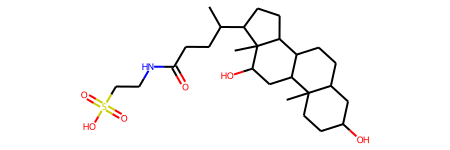

In [26]:
molplot_from_inchikey('AWDRATDZQPNJFN-VAYUFCLWSA-N')

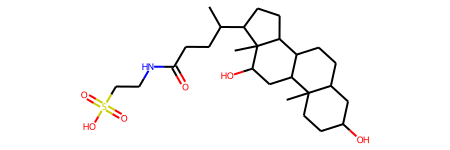

In [27]:
molplot_from_inchikey('AWDRATDZQPNJFN-GHMNEPPTSA-N')

In [9]:
string_search(data, 'reference_InChIKey', 'RFDAIACWWDREDC-FRVQLJSFSA-N')

,reference_Name,reference_InChIKey,reference_Mix,reference_Formula,reference_Monoisotopic mass,reference_adduct,reference_precursor_mz,retention_time,peaks_recalibrated,peaks_recalibrated_denoised,comments
703,Glycocholic Acid,RFDAIACWWDREDC-FRVQLJSFSA-N,PFPpos_P N 2_EAD,C26H43NO6,465.309038,[M+NH4]+,483.3429,2.042933,50.014914\t1.669367\n51.023315\t4.832007\n55.0...,50.014914\t1.669367\n51.023315\t4.832007\n55.0...,denoised
707,Glycocholic Acid,RFDAIACWWDREDC-FRVQLJSFSA-N,PFPpos_P N 2_EAD,C26H43NO6,465.309038,[M+H]+,466.3163,2.010650,50.014708\t1.747089\n51.022495\t4.838093\n55.0...,50.014708\t1.747089\n51.022495\t4.838093\n55.0...,denoised
708,Glycocholic Acid,RFDAIACWWDREDC-FRVQLJSFSA-N,PFPpos_P N 2_EAD,C26H43NO6,465.309038,[M+Na]+,488.2983,1.993433,50.015287\t5.211655\n51.022721\t10.420709\n52....,50.015287\t5.211655\n51.022721\t10.420709\n52....,denoised


In [11]:
entropy_similarity_default(string_search(data, 'reference_InChIKey', 'RFDAIACWWDREDC-FRVQLJSFSA-N').iloc[1]['peaks_recalibrated_denoised'],
                           string_search(data, 'reference_InChIKey', 'BHTRKEVKTKCXOH-BJLOMENOSA-N').iloc[0]['peaks_recalibrated_denoised'])

0.30460419533546346

In [14]:
string_search(data, 'reference_InChIKey', 'RFDAIACWWDREDC-FRVQLJSFSA-N').iloc[1]['reference_adduct']

'[M+H]+'

In [15]:
string_search(data, 'reference_InChIKey', 'BHTRKEVKTKCXOH-BJLOMENOSA-N').iloc[0]['reference_adduct']

'[M+H]+'

In [7]:
data['key']= data['reference_InChIKey']+data['reference_adduct']

In [8]:
len(data['reference_InChIKey'].unique())

1953

In [224]:
explained_intensity = []
for index, row in data.iterrows():
    explained_intensity.append(so.calculate_explained_intensity(row['peaks_recalibrated'], row['peaks_recalibrated_denoised'], row['reference_precursor_mz']))
data['explained_intensity']=explained_intensity

In [242]:
from toolsets.spectra_operations import normalized_entropy
normalized_entropy_one = []
normalized_entropy_forth = []
for index, row in data.iterrows():
    normalized_entropy_one.append(normalized_entropy(row['peaks_recalibrated_denoised'], order=1))
    normalized_entropy_forth.append(normalized_entropy(row['peaks_recalibrated_denoised'], order=4))
data['normalized_entropy_one']=normalized_entropy_one
data['normalized_entropy_forth']=normalized_entropy_forth

In [243]:
data_good_quality = num_search(data, 'explained_intensity', 90, '>', inclusion=True)

In [249]:
data_noisy = num_search(data, 'normalized_entropy_forth', 0.8, '>', inclusion=True)

In [253]:
data_non_informative = num_search(data, 'normalized_entropy_one', 0.5, '<', inclusion=True)

In [254]:
data_non_informative

,reference_Name,reference_InChIKey,reference_Mix,reference_Formula,reference_Monoisotopic mass,reference_adduct,reference_precursor_mz,retention_time,peaks_recalibrated,peaks_recalibrated_denoised,comments,explained_intensity,normalized_entropy_one,normalized_entropy_forth
66,"N,N-Dimethylglycine",FFDGPVCHZBVARC-UHFFFAOYSA-N,GC LIB 5,C4H9NO2,103.063328,[M+H]+,104.0706,1.955650,56.049357\t8.982489\n57.056548\t1.012778\n57.8...,56.049357\t8.982489\n57.056548\t1.012778\n58.0...,denoised,98.62514,0.304339,0.008579
181,4-ethoxy-N-(2-phenylethyl)benzamide,GCXWAEJLLFKQFQ-UHFFFAOYSA-N,Pandemic 12,C17H19NO2,269.141579,[M+H]+,270.1489,0.195617,121.030189\t16.610691\n132.046474\t1.639989\n1...,121.030189\t16.610691\n132.046474\t1.639989\n1...,denoised,98.02025,0.496860,0.060945
307,N-[(4-fluorophenyl)methyl]-4-hydroxy-2-oxo-1H-...,YTQNZGHPUXHBMQ-UHFFFAOYSA-N,Pandemic 18,C16H12FN3O3,313.086269,[M+H]+,314.0935,0.244267,133.040703\t2.640294\n175.052518\t2.931664\n17...,133.040703\t2.640294\n175.052518\t2.931664\n17...,denoised,97.30179,0.352178,0.015383
497,"N-(4-methoxyphenyl)pyrazolo[1,5-a]pyridine-2-c...",OOQFUDGMLSSZNX-UHFFFAOYSA-N,Pandemic 9,C15H13N3O2,267.100777,[M+H]+,268.1081,0.200350,117.04045\t3.222095\n144.564671\t1.77298\n145....,117.04045\t3.222095\n145.04565\t100.0\n207.083...,denoised,98.66184,0.453497,0.042296
526,Zoxazolamine,YGCODSQDUUUKIV-UHFFFAOYSA-N,Pathogen 1,C7H5ClN2O,168.009040,[M+H]+,169.0163,0.208667,126.993533\t10.189719\n128.060601\t1.25459\n13...,126.993533\t10.189719\n133.037348\t1.22399\n13...,denoised,93.17269,0.494078,0.059591
715,Indole-3-Acetamide,ZOAMBXDOGPRZLP-UHFFFAOYSA-N,MSMLS 21,C10H10N2O,174.079313,[M+H]+,175.0866,0.239467,128.051565\t20.896697\n129.057506\t1.955\n129....,128.051565\t20.896697\n129.057506\t1.955\n130....,denoised,99.11892,0.417162,0.030285
818,PYROCATECHUIC ACID,GLDQAMYCGOIJDV-UHFFFAOYSA-N,PFPpos_POS 1_EAD,C7H6O4,154.026609,[M+H]+,155.0339,0.617400,127.055021\t2.237659\n128.063131\t5.889224\n12...,127.055021\t2.237659\n136.015146\t3.731481\n13...,denoised,84.65354,0.231207,0.002858
1388,"1-(4-hydroxyphenyl)-3-[(2R,3R,4S,5S,6R)-3,4,5-...",NPAQHLFPEOMKAL-UXXRCYHCSA-N,PFPpos_POS 8_EAD,C15H20O8,328.115818,[M+H]+,329.1231,0.286833,121.029475\t10.53818\n127.048507\t1.056636\n12...,121.029475\t10.53818\n127.048507\t1.056636\n12...,denoised,100.00000,0.461216,0.045250
1389,"1-(4-hydroxyphenyl)-3-[(2R,3R,4S,5S,6R)-3,4,5-...",NPAQHLFPEOMKAL-UXXRCYHCSA-N,PFPpos_POS 8_EAD,C15H20O8,328.115818,[M+NH4]+,346.1496,0.288550,121.029094\t5.233374\n128.057977\t1.392987\n13...,121.029094\t5.233374\n128.057977\t1.392987\n13...,denoised,99.12622,0.348186,0.014698
1674,Helicin,BGOFCVIGEYGEOF-UJPOAAIJSA-N,PFPpos_P N 2_EAD,C13H16O7,284.089603,[M+NH4]+,302.1234,0.288100,115.052732\t2.361324\n117.061378\t1.678248\n12...,115.052732\t2.361324\n117.061378\t1.678248\n12...,denoised,98.32239,0.483199,0.054514


i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot


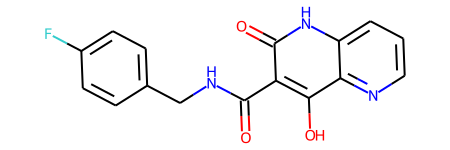

In [257]:
from toolsets.ms2_spectra_plotter import molplot_from_inchikey
molplot_from_inchikey(data_non_informative.iloc[2]['reference_InChIKey'])

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

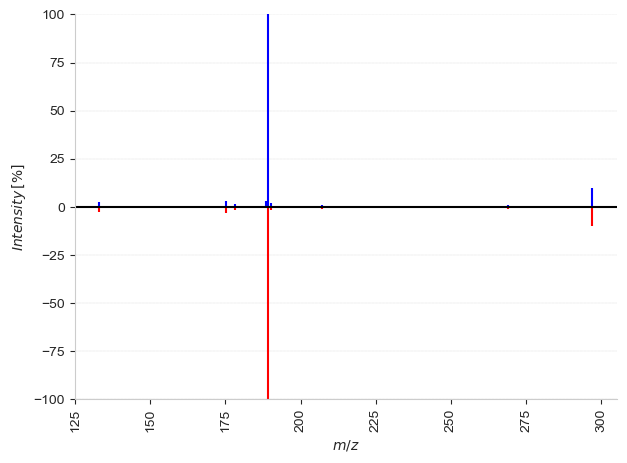

In [255]:
head_to_tail_plot(data_non_informative.iloc[2]['peaks_recalibrated'],data_non_informative.iloc[2]['peaks_recalibrated_denoised'], identity=True, savepath=os.path.join(source_dir, 'non-informative.tiff'))

In [269]:
data_non_informative.iloc[2]

reference_Name                 N-[(4-fluorophenyl)methyl]-4-hydroxy-2-oxo-1H-...
reference_InChIKey                                   YTQNZGHPUXHBMQ-UHFFFAOYSA-N
reference_Mix                                                        Pandemic 18
reference_Formula                                                    C16H12FN3O3
reference_Monoisotopic mass                                           313.086269
reference_adduct                                                          [M+H]+
reference_precursor_mz                                                  314.0935
retention_time                                                          0.244267
peaks_recalibrated             133.040703\t2.640294\n175.052518\t2.931664\n17...
peaks_recalibrated_denoised    133.040703\t2.640294\n175.052518\t2.931664\n17...
comments                                                                denoised
explained_intensity                                                     97.30179
normalized_entropy_one      

In [270]:
100-97.30179

2.698210000000003

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

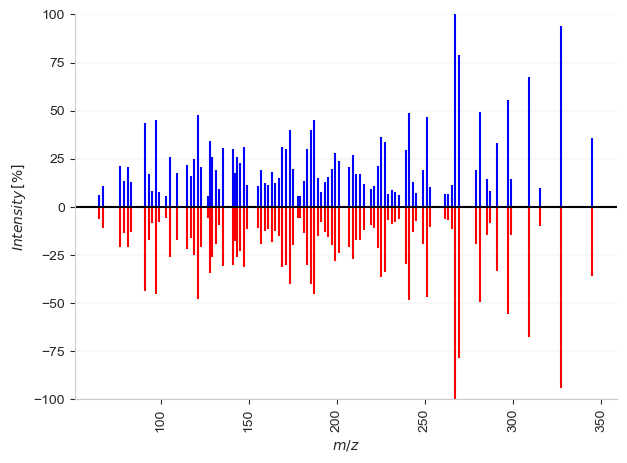

In [252]:
head_to_tail_plot(data_noisy.iloc[1]['peaks_recalibrated'],data_noisy.iloc[1]['peaks_recalibrated_denoised'], identity=True, savepath=os.path.join(source_dir, 'noisy.tiff'))

In [268]:
data_noisy.iloc[1]

reference_Name                                                          Cortisol
reference_InChIKey                                   JYGXADMDTFJGBT-VWUMJDOOSA-N
reference_Mix                                                           MSMLS 18
reference_Formula                                                       C21H30O5
reference_Monoisotopic mass                                           362.209324
reference_adduct                                                          [M+H]+
reference_precursor_mz                                                  363.2166
retention_time                                                            0.2499
peaks_recalibrated             65.036754\t6.451719\n67.053157\t10.96563\n77.0...
peaks_recalibrated_denoised    65.036754\t6.451719\n67.053157\t10.96563\n77.0...
comments                                                                denoised
explained_intensity                                                        100.0
normalized_entropy_one      

In [246]:
data_good_quality.iloc[8]

reference_Name                                   D-Pantothenic Acid Calcium Salt
reference_InChIKey                                   GHOKWGTUZJEAQD-UHFFFAOYSA-N
reference_Mix                                                           GC LIB 1
reference_Formula                                                       C9H17NO5
reference_Monoisotopic mass                                           219.110673
reference_adduct                                                         [M+Na]+
reference_precursor_mz                                                  242.0999
retention_time                                                           0.60105
peaks_recalibrated             50.015801\t2.105584\n51.02369\t10.558437\n52.0...
peaks_recalibrated_denoised    50.015801\t2.105584\n51.02369\t10.558437\n52.0...
comments                                                                denoised
explained_intensity                                                     98.94552
normalized_entropy_one      

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

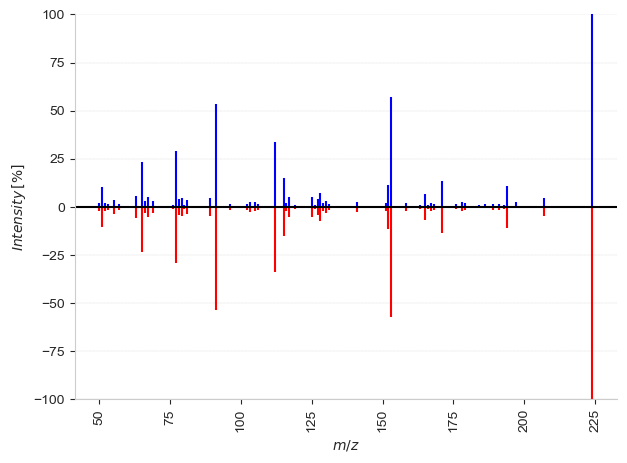

In [248]:
head_to_tail_plot(data_good_quality.iloc[8]['peaks_recalibrated'],data_good_quality.iloc[8]['peaks_recalibrated_denoised'], identity=True, savepath=os.path.join(source_dir, 'good_quality.tiff'))

In [261]:
data_good_quality.iloc[8]

reference_Name                                   D-Pantothenic Acid Calcium Salt
reference_InChIKey                                   GHOKWGTUZJEAQD-UHFFFAOYSA-N
reference_Mix                                                           GC LIB 1
reference_Formula                                                       C9H17NO5
reference_Monoisotopic mass                                           219.110673
reference_adduct                                                         [M+Na]+
reference_precursor_mz                                                  242.0999
retention_time                                                           0.60105
peaks_recalibrated             50.015801\t2.105584\n51.02369\t10.558437\n52.0...
peaks_recalibrated_denoised    50.015801\t2.105584\n51.02369\t10.558437\n52.0...
comments                                                                denoised
explained_intensity                                                     98.94552
normalized_entropy_one      

In [263]:
100-98.94552

1.054479999999998

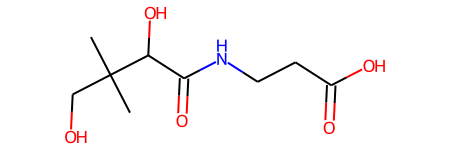

In [259]:
molplot_from_inchikey(data_good_quality.iloc[8]['reference_InChIKey'])

In [237]:
data_bad_quality=num_search(data, 'explained_intensity', 20, '<', inclusion=True)

In [238]:
data_bad_quality

,reference_Name,reference_InChIKey,reference_Mix,reference_Formula,reference_Monoisotopic mass,reference_adduct,reference_precursor_mz,retention_time,peaks_recalibrated,peaks_recalibrated_denoised,comments,explained_intensity
234,"5-Iodo-6-amino-1,2-benzopyrone",WWRAFPGUBABZSD-UHFFFAOYSA-N,Pandemic 15,C9H6INO2,286.944325,[M+H]+,287.9516,0.214583,132.045825\t5.628332\n133.049764\t2.688886\n13...,132.045825\t5.628332\n133.049764\t2.688886\n13...,denoised,11.64441
1646,Juglone,KQPYUDDGWXQXHS-UHFFFAOYSA-N,PFPpos_P N 1_EAD,C10H6O3,174.031694,[M+H]+,175.0390,2.182167,112.999544\t9.525539\n115.053797\t94.479122\n1...,112.999544\t9.525539\n115.053797\t94.479122\n1...,denoised,17.00706


In [239]:
from toolsets.ms2_spectra_plotter import head_to_tail_plot

i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot


In [264]:
data_bad_quality.iloc[1]

reference_Name                                                           Juglone
reference_InChIKey                                   KQPYUDDGWXQXHS-UHFFFAOYSA-N
reference_Mix                                                   PFPpos_P N 1_EAD
reference_Formula                                                        C10H6O3
reference_Monoisotopic mass                                           174.031694
reference_adduct                                                          [M+H]+
reference_precursor_mz                                                   175.039
retention_time                                                          2.182167
peaks_recalibrated             112.999544\t9.525539\n115.053797\t94.479122\n1...
peaks_recalibrated_denoised    112.999544\t9.525539\n115.053797\t94.479122\n1...
comments                                                                denoised
explained_intensity                                                     17.00706
Name: 1646, dtype: object

In [267]:
normalized_entropy(data_bad_quality.iloc[1]['peaks_recalibrated_denoised'], order = 4)

0.4380508928497239

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

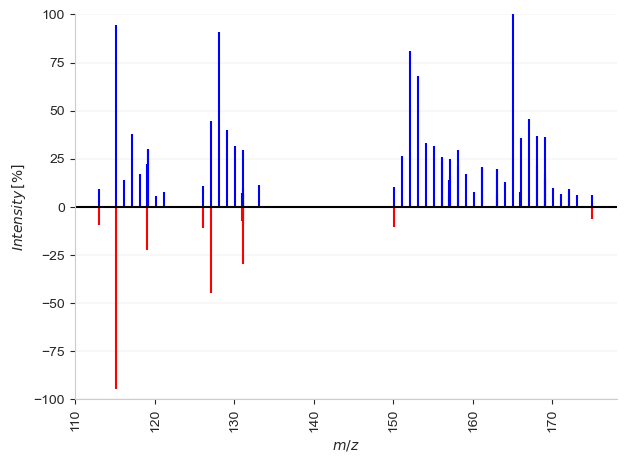

In [241]:
head_to_tail_plot(data_bad_quality.iloc[1]['peaks_recalibrated'],data_bad_quality.iloc[1]['peaks_recalibrated_denoised'], identity=True, savepath=os.path.join(source_dir, 'bad_quality.tiff'))

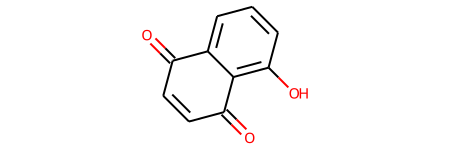

In [260]:
molplot_from_inchikey(data_bad_quality.iloc[1]['reference_InChIKey'])

In [220]:
(3280-3575)/3575

-0.08251748251748252

In [81]:
len(data_good_quality['reference_InChIKey'].unique())

1823

In [83]:
data_good_quality.head()

,reference_Name,reference_InChIKey,reference_Mix,reference_Formula,reference_Monoisotopic mass,reference_adduct,reference_precursor_mz,retention_time,peaks_recalibrated,peaks_recalibrated_denoised,comments,key,explained_intensity
0,Tauroursodeoxycholic acid,BHTRKEVKTKCXOH-LBSADWJPSA-N,Bile acids 1,C26H45NO6S,499.296759,[M+H]+,500.3040,5.751050,51.024371\t3.514247\n55.057286\t1.316147\n63.0...,51.024371\t3.514247\n55.057286\t1.316147\n63.0...,denoised,BHTRKEVKTKCXOH-LBSADWJPSA-N[M+H]+,100.00000
1,Taurodehydrocholate,UBDJSBRKNHQFPD-PYGYYAGESA-N,Bile acids 1,C26H39NO7S,509.244724,[M+H]+,510.2520,2.198233,50.017549\t3.52349\n51.025134\t11.744967\n53.0...,50.017549\t3.52349\n51.025134\t11.744967\n53.0...,denoised,UBDJSBRKNHQFPD-PYGYYAGESA-N[M+H]+,100.00000
2,Glycochenodeoxycholic acid,GHCZAUBVMUEKKP-GYPHWSFCSA-N,Bile acids 1,C26H43NO5,449.314123,[M+H]+,450.3214,2.304017,50.016725\t1.639344\n51.025122\t5.071469\n53.0...,50.016725\t1.639344\n51.025122\t5.071469\n53.0...,denoised,GHCZAUBVMUEKKP-GYPHWSFCSA-N[M+H]+,99.59382
3,Deoxycholic Acid,KXGVEGMKQFWNSR-LLQZFEROSA-N,PFPpos_POS 2_EAD,C24H40O4,392.292660,[M+H]+,393.2999,2.302233,50.015884\t7.533414\n51.023678\t20.291616\n52....,50.015884\t7.533414\n51.023678\t20.291616\n52....,denoised,KXGVEGMKQFWNSR-LLQZFEROSA-N[M+H]+,99.87746
4,Taurodeoxycholic acid,AWDRATDZQPNJFN-VAYUFCLWSA-N,Bile acids 3,C26H45NO6S,499.296759,[M+H]+,500.3040,5.246883,51.024091\t3.276298\n55.055206\t1.706543\n63.0...,51.024091\t3.276298\n55.055206\t1.706543\n63.0...,denoised,AWDRATDZQPNJFN-VAYUFCLWSA-N[M+H]+,100.00000


In [10]:
adduct_results = data_good_quality['reference_adduct'].value_counts().rename_axis('adduct').reset_index(name='counts')

In [11]:
adduct_results

,adduct,counts
0,[M+H]+,1462
1,[M+Na]+,1064
2,[M+NH4]+,754


# adduct distribution

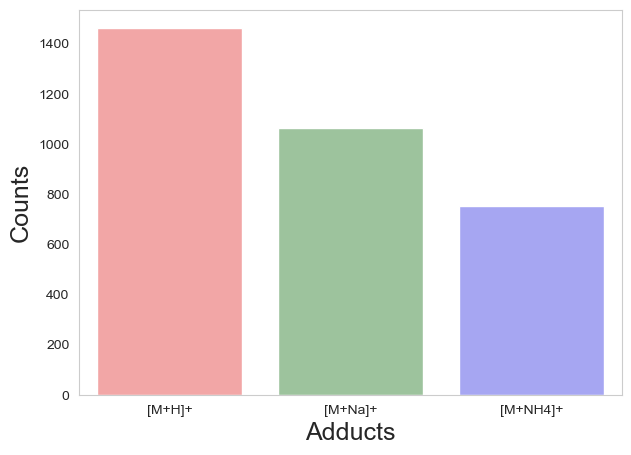

In [78]:
fig, ax = plt.subplots(
    figsize = (7, 5)
                      )
colors = ['#FF9999','#97C997','#9999FF']
sns.barplot(x = adduct_results['adduct'], y = adduct_results['counts'], palette = colors)
ax.set_xlabel("Adducts", fontsize = 18)
ax.set_ylabel("Counts", fontsize = 18)
ax.grid(False)
plt.savefig(os.path.join(source_dir,'adducts_distribution.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

In [82]:
from toolsets.API_gets import GNPS_classyfire
chemical_classes = []
for index, row in tqdm(data_good_quality.iterrows(), total = len(data_good_quality)):
    # break
    chemical_classes.append(GNPS_classyfire(inputt = row['reference_InChIKey'],class_type='class'))

100%|██████████| 3280/3280 [16:02<00:00,  3.41it/s]


# adduct distribution: Venn diagram

In [27]:
# from matplotlib import matplotlib_venn
import matplotlib_venn as venn

# df_dataset = pd.read_csv('...path...',delimiter=',',decimal=',')
M_H = data_good_quality[(data_good_quality['reference_adduct'] == '[M+H]+')]
M_Na = data_good_quality[(data_good_quality['reference_adduct'] == '[M+Na]+')]
M_NH4 = data_good_quality[(data_good_quality['reference_adduct'] == '[M+NH4]+')]

#
# plt.figure(figsize=(4,4))
# set1 = set(campaign_a['CLI_ID'])
# set2 = set(campaign_b['CLI_ID'])
#
# venn2([set1, set2], ('Set1', 'Set2'))
# plt.show()

In [44]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted, venn3_circles, venn3
set1 = set(string_search(data_good_quality,'reference_adduct','[M+H]+')['reference_InChIKey'])
set2 = set(string_search(data_good_quality,'reference_adduct','[M+Na]+')['reference_InChIKey'])
set3 = set(string_search(data_good_quality,'reference_adduct','[M+NH4]+')['reference_InChIKey'])
fig, ax = plt.subplots(
    figsize = (7, 5)
                      )
venn3([set1, set2, set3], ('[M+H]+', '[M+Na]+', '[M+NH4]+'))

# plt.show()
# plt.savefig(os.path.join(source_dir,'venn_diagram.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

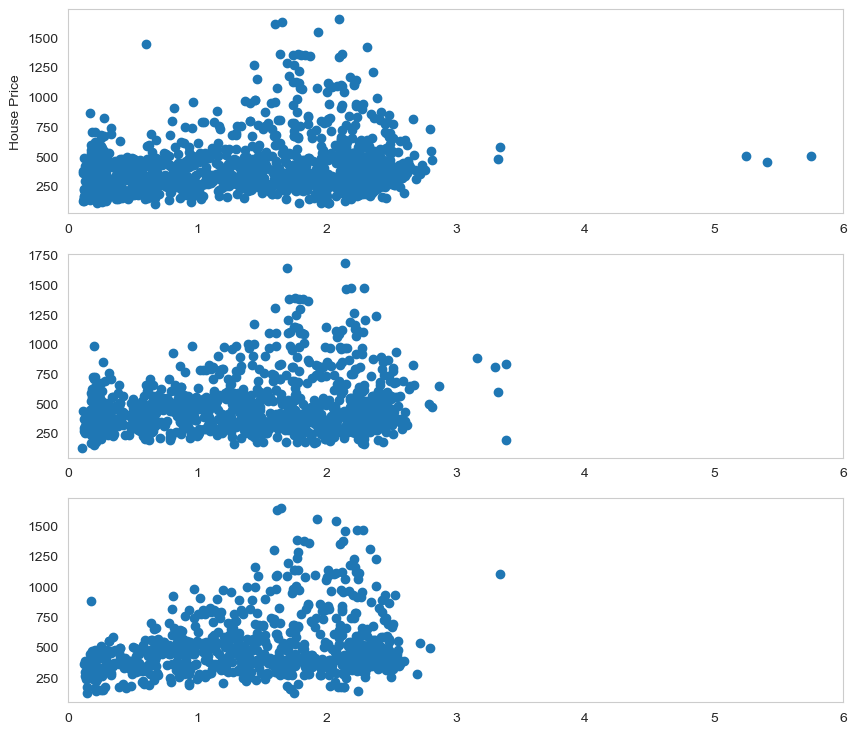

In [62]:
# fig, ax = plt.subplots(3, figsize=(10, 9))
# ax[0].scatter(x = string_search(data_good_quality,'reference_adduct','[M+H]+')['retention_time'], y = string_search(data_good_quality,'reference_adduct','[M+H]+')['reference_precursor_mz'])
# ax[0].set_xlabel("")
# ax[0].set_ylabel("House Price")
# ax[0].set_xlim(left = 0, right=6)
# ax[1].scatter(x = string_search(data_good_quality,'reference_adduct','[M+Na]+')['retention_time'], y = string_search(data_good_quality,'reference_adduct','[M+Na]+')['reference_precursor_mz'])
# ax[1].set_xlim(left = 0, right=6)
# # ax[1].set_xlabel("Overall Quality")
# # ax[1].set_ylabel("House Price")
# ax[2].scatter(x = string_search(data_good_quality,'reference_adduct','[M+NH4]+')['retention_time'], y = string_search(data_good_quality,'reference_adduct','[M+NH4]+')['reference_precursor_mz'])
# ax[2].set_xlim(left = 0, right=6)
# ax[0].grid(False)
# ax[1].grid(False)
# ax[2].grid(False)
# plt.show()

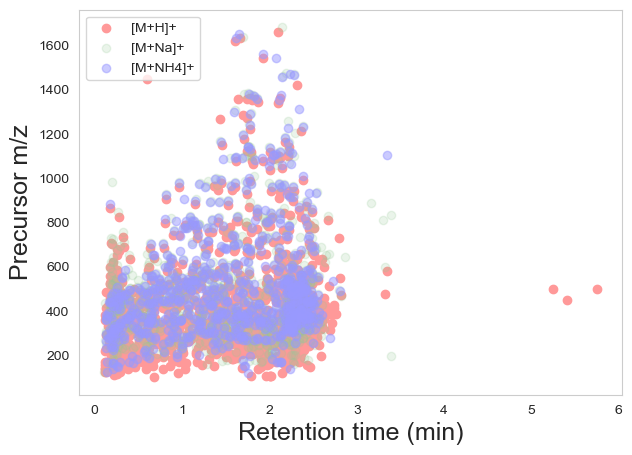

In [76]:
# fig, ax = plt.subplots(
#     figsize = (7, 5)
#                       )
fig = plt.figure(figsize = (7, 5))
ax1 = fig.add_subplot()

ax1.scatter(x = string_search(data_good_quality,'reference_adduct','[M+H]+')['retention_time'], y = string_search(data_good_quality,'reference_adduct','[M+H]+')['reference_precursor_mz'], label = '[M+H]+', color = '#FF9999')
ax1.scatter(x = string_search(data_good_quality,'reference_adduct','[M+Na]+')['retention_time'], y = string_search(data_good_quality,'reference_adduct','[M+Na]+')['reference_precursor_mz'],label = '[M+Na]+', alpha=0.2,color = '#97C997')
ax1.scatter(x = string_search(data_good_quality,'reference_adduct','[M+NH4]+')['retention_time'], y = string_search(data_good_quality,'reference_adduct','[M+NH4]+')['reference_precursor_mz'], label  = '[M+NH4]+',alpha=0.5, color = '#9999FF')
plt.legend(loc='upper left')
ax1.grid(False)
ax1.set_xlabel("Retention time (min)",fontsize = 18)
ax1.set_ylabel("Precursor m/z", fontsize = 18)
# ax.set_xlabel("Retention Time (Min)", fontsize = 18)
# ax.set_ylabel("Precursor m/z", fontsize = 18)
# plt.show()
plt.savefig(os.path.join(source_dir,'rt_premz.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

# rt_mz distribution

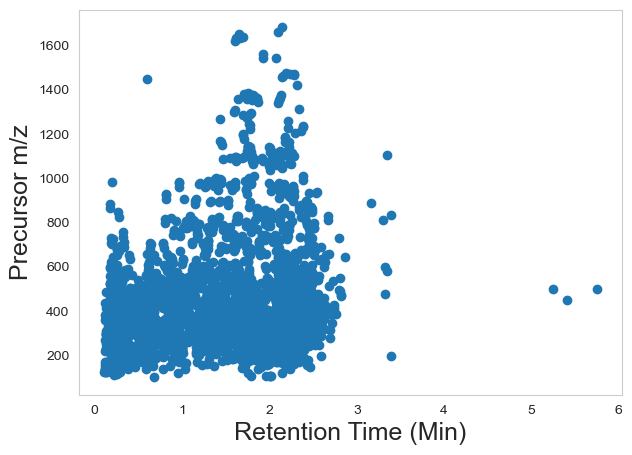

In [152]:
fig, ax = plt.subplots(
    figsize = (7, 5)
                      )
plt.scatter(data_good_quality['retention_time'], data_good_quality['reference_precursor_mz'])
# ax= sns.histplot(data=data, x="normalized_entroy_denoised", multiple="stack", kde = True,
#                  # hue="evaluations"
#                  )
# ax.yaxis
# plt.vlines(x =0.8, ymin = 0, ymax=250,colors='red')
# ax = sns.histplot(data=data_ead_r, x="diff_recalibrated", multiple="stack", kde = True,color = "green")
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Retention Time (Min)", fontsize = 18)
ax.set_ylabel("Precursor m/z", fontsize = 18)
ax.grid(False)
# plt.legend(labels=["Before recalibration","After recalibration"], loc = 'upper right')
plt.savefig(os.path.join(source_dir,'rt_premz.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

# pie chart for chemical classes

In [ ]:
data_good_quality['chemical_classes']=chemical_classes

In [129]:
class_results = data_good_quality.loc[data_good_quality['chemical_classes']!='inchi_not_found']['chemical_classes'].value_counts().rename_axis('chemical_classes').reset_index(name='counts')

In [136]:
data_good_quality.columns

Index(['reference_Name', 'reference_InChIKey', 'reference_Mix',
       'reference_Formula', 'reference_Monoisotopic mass', 'reference_adduct',
       'reference_precursor_mz', 'retention_time', 'peaks_recalibrated',
       'peaks_recalibrated_denoised', 'comments', 'key', 'explained_intensity',
       'chemical_classes'],
      dtype='object')

In [130]:
labels = []
for i in range(0,15):
    labels.append(class_results.iloc[i]['chemical_classes']+' '+str(np.round(class_results.iloc[i]['counts']/sum(class_results.iloc[0:15]['counts'])*100,1))+ '%')

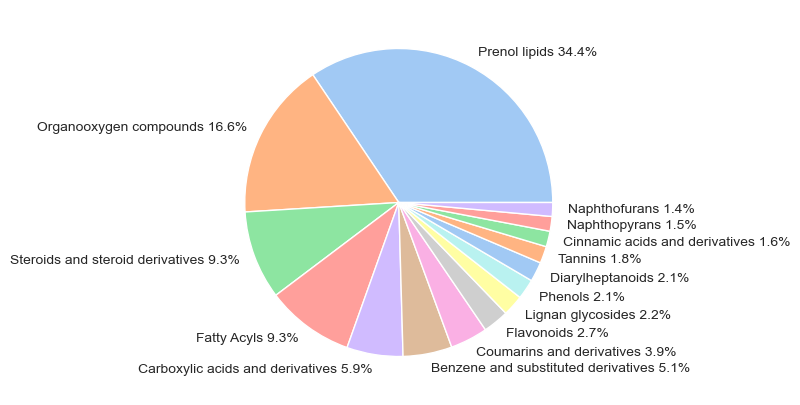

In [134]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(
    figsize = (10, 5)
                      )
# labels=[f'{class_results.iloc[i]['Class']} {np.round(class_results.iloc[i]['counts']/sum(class_results.iloc[0:15]['counts'])*100,1)}%' for i in range(0,15)]
colors = sns.color_palette('pastel')[0:15]
plt.pie(class_results.iloc[0:15]['counts'], labels = labels,colors = colors
        # ,autopct='%.0f%%'
        )
# plt.show()
plt.savefig(os.path.join(source_dir, 'pie_chart.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

# searching biological samples